* https://github.com/timestocome

    
This problem is just a slight variation on MNIST. It's a different number set and there is a labeled 
training set, a labeled holdout set and an unlabeled set for submitting to Kaggle.

What makes it interesting is that all 3 sets of integers have different std, means

The best way to solve this problem is to augment the data, shift and scale the training data to match the 
holdout and or submission set and run it through a convolutional network. Using all the 40,000 training data,
augmenting it and using a standard convolutional network will score 98%

But what if that wasn't an option? Using only 4000 labeled samples of 40,000 in the set and 4000 unlabeled samples accuracy can hit 81%

Using a Semi-Supervised GAN gives 5% better accuracy than the conventional method if you only have a limited amount of labeled data 





# Kannada MNIST Semi-Supervised GAN

* Model small set of Kannada MNIST samples of 40,000 samples
* Holdout and Submission imgs vary from test data in std, mean

While the GAN slightly outperforms a stardard Supervised FF Conv on Test Data that differs from Training Data it's not by a large amount. Augmenting data and shifting the std and mean to match Test Data is probably a better option


### Use labeled and unlabeled data from the training set ( same std, mean )

|n_train samples| GAN validation | GAN holdout | Supervised validation | Supervised holdout |
| --- | --- | --- | --- | --- |
| 1000 | 98% | 72% | 97% | 67% |
| 2000 | 98% | 70% | 97% | 62% |
| 3000 | 98% | 72% | 98% | 70% |
| 4000 | 98% | 72% | 97% | 67% |
| 5000 | 99% | 71% | 98% | 65% |
| 6000 | 99% | 76% | 98% | 67% |
| 8000 | 99% | 72% | 98% | 67% |
| 10000 | 99% | 75% | 98% | 70% |
| 12000 | 99% | 75% | 99% | 74% | 


### Use unlabeled holdout set as unlabeled data for GAN ( different std, mean) check against unlabeled set

|n_train samples| GAN validation | GAN holdout |
| --- | --- | --- | 
| 1000 | 98% | 79% |
| 2000 | 98% | 78% | 
| 3000 | 98% | % | 
| 4000 | 98% | 80% | 
| 5000 | 99% | % | 
| 6000 | 99% | 81% | 
| 8000 | 99% | % | 
| 10000 | 99% | 72% | 
| 12000 | 99% | % | 

### Use Submission as unlabeled, check against holdout labeled data (all sets have diff std, mean) 
4000 training samples yeilds 73% accuracy



* example code and images from https://www.manning.com/books/gans-in-action
* dataset https://www.kaggle.com/c/Kannada-MNIST

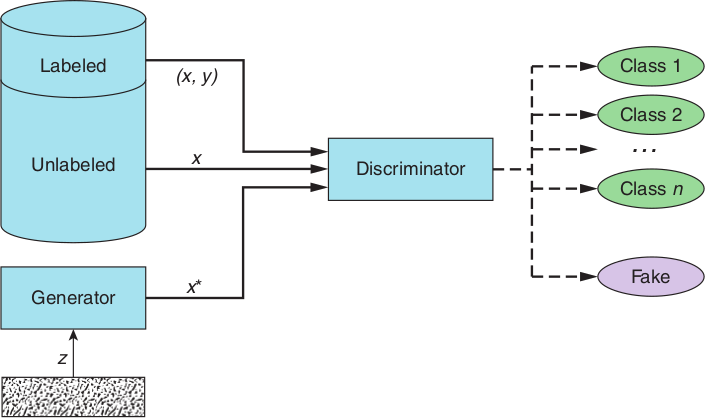


* Reducing the Need for Labeled Data in Generative Adversarial Networks https://ai.googleblog.com/2019/03/reducing-need-for-labeled-data-in.html

* Self-Supervised GANs via Auxiliary Rotation Loss  https://arxiv.org/pdf/1811.11212.pdf

* Unsupervised Representation Learning by Predicting Image Rotations  https://arxiv.org/abs/1803.07728




Kannada is a language spoken predominantly by people of Karnataka in southwestern India. The language has roughly 45 million native speakers and is written using the Kannada script.

The goal of this Kaggle competition is to use machine learning to correctly label hand-written digits written in the Kannada script. The Kannada dataset format is based on the dataset used in the original MNIST dataset where the objective was the same but the hand-written digits were Arabic numbers.



In [1]:
# silence is golden

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)


In [2]:
# hack to make keras work with 2*** series gpus

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from keras import backend as K

from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Dropout, Flatten, Input, Lambda, Reshape)

from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical

Using TensorFlow backend.


In [4]:
# Kannada MNIST dataset ~ 60,000 samples
# 40,000 labeled train
# 5,000 unlabeled submission
# 10,240 labeled holdout
# find labeled data, split out 100 samples for training


train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
holdout = pd.read_csv('input/Dig-MNIST.csv')


# label, image
print('train', train.shape)
print(train.columns)


# id, image
print('test', test.shape)
print(test.columns)


# label, image
print('holdout', holdout.shape)
print(holdout.columns)


train (60000, 785)
Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)
test (5000, 785)
Index(['id', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)
holdout (10240, 785)
Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)


Train
Test
Holdout


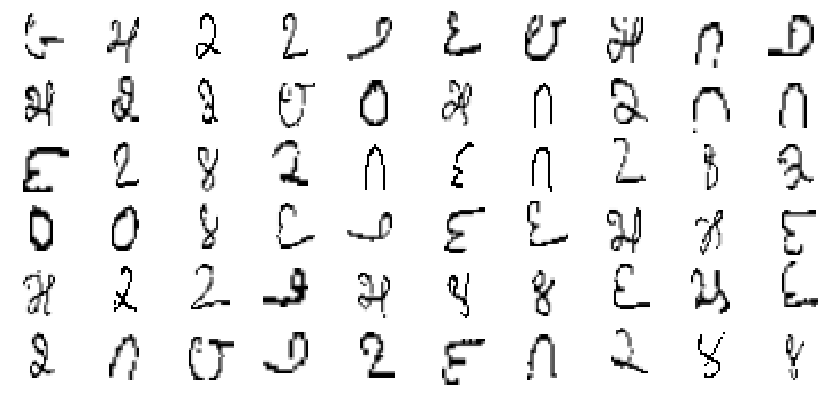

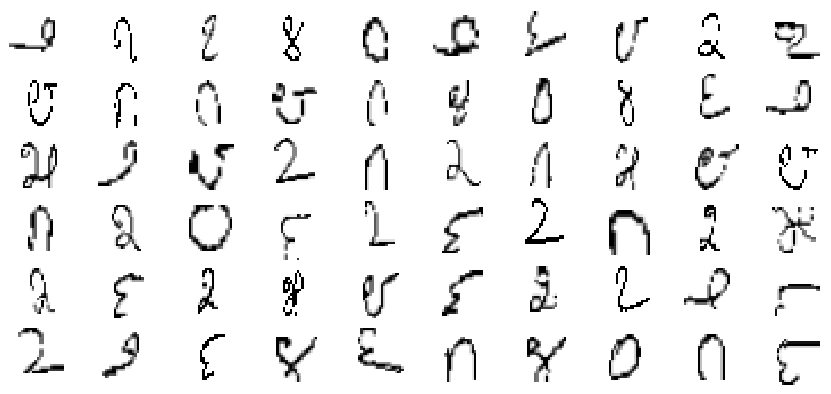

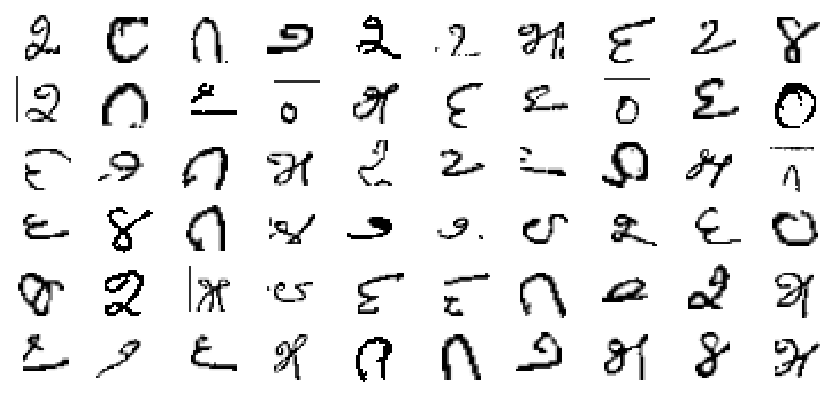

In [5]:

def show_imgs(df, n):

    fig, ax = plt.subplots(n, 10)
    
    for i in range(n):
        for j in range(10):
            r = np.random.randint(0, len(df))
            number = df.iloc[r].values.reshape((28,28))
            ax[i][j].imshow(number, cmap=plt.cm.binary)
            ax[i][j].axis('off')
            
    plt.subplots_adjust(wspace=0, hspace=0)        
    fig.set_figwidth(15)
    fig.set_figheight(7)
    fig.show()
    
    
    
print('Train')    
train_imgs = train.drop(columns=['label'])
show_imgs(train_imgs, 6)

print('Test')
test_imgs = test.drop(columns=['id'])
show_imgs(test_imgs, 6)

print('Holdout')
holdout_imgs = holdout.drop(columns=['label'])
show_imgs(holdout_imgs, 6)
    
    
    
    

In [6]:
# split into x image, y label, train -> train/validate

# this is the labeled part of the training set, rest of training data is held aside
num_labeled = 4000


# shuffle train set
train_s = train.sample(frac=1.)
train = train_s[0:30000]
validate = train_s[30000:40000]

print(train.shape, validate.shape)


# split into labeled and unlabeled
train_labeled = train[0:num_labeled]
train_unlabeled = train[num_labeled:len(train)]


y_train_labeled = train_labeled.label.values
x_train_labeled = train_labeled.drop(columns=['label']).values

y_train_unlabeled = train_unlabeled.label.values
x_train_unlabeled = train_unlabeled.drop(columns=['label']).values


y_validate = validate.label.values
x_validate = validate.drop(columns=['label']).values



x_submission = test.drop(columns=['id']).values

y_holdout = holdout.label.values
x_holdout = holdout.drop(columns=['label']).values

print('labeled train', x_train_labeled.shape, y_train_labeled.shape)
print('unlabeled train', x_train_unlabeled.shape, y_train_unlabeled.shape)

print('submission', x_submission.shape)
print('holdout', x_holdout.shape, y_holdout.shape)


(30000, 785) (10000, 785)
labeled train (4000, 784) (4000,)
unlabeled train (26000, 784) (26000,)
submission (5000, 784)
holdout (10240, 784) (10240,)


In [7]:
# shift and scale image data
def scale_shift(x):
    return x / 255.
    #return (x-127.5)/(2 * x.std())



x_train_unlabeled = scale_shift(x_train_unlabeled)
x_train_labeled = scale_shift(x_train_labeled)
x_validate = scale_shift(x_validate)
x_holdout = scale_shift(x_holdout)
x_submission = scale_shift(x_submission)



print(x_train_unlabeled.std(), x_train_labeled.std(), x_validate.std(), x_holdout.std(), x_submission.std())
print(x_train_unlabeled.mean(), x_train_labeled.mean(), x_validate.mean(), x_holdout.mean(), x_submission.mean())
print(x_train_unlabeled.min(), x_train_labeled.min(), x_validate.min(), x_holdout.min(), x_submission.min())
print(x_train_unlabeled.max(), x_train_labeled.max(), x_validate.max(), x_holdout.max(), x_submission.max())




0.24174378301088834 0.24204190658544242 0.24159372845260682 0.2860085202946692 0.22543569156630952
0.08227740346138461 0.08255890856342538 0.08211163415366142 0.11264889842655808 0.07261260104041618
0.0 0.0 0.0 0.0 0.0
1.0 1.0 1.0 1.0 1.0


In [8]:


# Expand image dimensions to width x height x channels
def reshape_img_data(x):
    return np.expand_dims(x, axis=3)


print(x_train_unlabeled.shape, x_train_labeled.shape, x_validate.shape, x_holdout.shape, x_submission.shape)



# labels
def reshape_labels(y):
    return y.reshape(-1, 1)
    
y_train_unlabeled = reshape_labels(y_train_unlabeled)
y_train_labeled = reshape_labels(y_train_labeled)
y_validate = reshape_labels(y_validate)
y_holdout = reshape_labels(y_holdout)

print(y_train_unlabeled.shape, y_train_labeled.shape, y_validate.shape, y_holdout.shape)

(26000, 784) (4000, 784) (10000, 784) (10240, 784) (5000, 784)
(26000, 1) (4000, 1) (10000, 1) (10240, 1)


In [9]:
# train labels 0..9, equal numbers of each
print(y_train_unlabeled.min(), y_train_unlabeled.max())
print(y_train_labeled.min(), y_train_labeled.max())

print(np.unique(y_train_labeled, return_counts=True))
print(np.unique(y_train_unlabeled, return_counts=True))


print(y_holdout.min(), y_holdout.max())
print(np.unique(y_holdout, return_counts=True))

0 9
0 9
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([394, 385, 442, 365, 374, 426, 375, 412, 419, 408]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([2607, 2638, 2595, 2555, 2609, 2620, 2605, 2647, 2539, 2585]))
0 9
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024]))


In [10]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset
num_classes = 10

In [11]:




# random batch of labeled train data
def batch_labeled(batch_size):
        
    x = x_train_labeled
    y = y_train_labeled
        
    # Get a random batch of labeled images and their labels
    idx = np.random.randint(0, num_labeled, batch_size)
    imgs = x[idx]
    labels = y[idx]
    
    imgs = imgs.reshape(batch_size, img_rows, img_cols, 1)
    labels = to_categorical(labels, num_classes=num_classes)

    return imgs, labels

    
# random batch unlabeled train data    
def batch_unlabeled(batch_size):
        
    x = x_train_unlabeled
    y = y_train_unlabeled
        
        
    # Get a random batch of unlabeled images
    idx = np.random.randint(num_labeled, x.shape[0], batch_size)
    imgs = x[idx]
    
    imgs = imgs.reshape(batch_size, img_rows, img_cols, 1)

        
    return imgs


# full training set
def train_set():
    
    imgs = np.concatenate((x_train_labeled, x_train_unlabeled), axis=0)
    y = np.concatenate((y_train_labeled, y_train_unlabeled), axis=0)
    
    imgs = imgs.reshape(len(imgs), img_rows, img_cols, 1)
    labels = to_categorical(y, num_classes=num_classes)

    
    return imgs, labels


    

# validation set is a random selection of samples from train set
def test_set():
     
    imgs = x_validate
    y = y_validate
    
    imgs = imgs.reshape(len(imgs), img_rows, img_cols, 1)
    labels = to_categorical(y, num_classes=num_classes)

    return imgs, labels
    
    
    
# unseen set, somewhat different std and mean in images
def holdout_set():
        
    imgs = x_holdout
    y = y_holdout
    
    imgs = imgs.reshape(len(imgs), img_rows, img_cols, 1)
    labels = to_categorical(y, num_classes=num_classes)

    return imgs, labels
    

# unseen set, somewhat different std and mean in images
def submission_set():
        
    imgs = x_submission
    imgs = imgs.reshape(len(imgs), img_rows, img_cols, 1)

    return imgs




######################################################################
# experimental
# use unlabeled holdout and validation data as unlabeled instead of part
#    of the training set
    
# random batch unlabeled train data    
def batch_holdout(batch_size):
        
    x = x_holdout
        
    # Get a random batch of unlabeled images
    idx = np.random.randint(num_labeled, x.shape[0], batch_size)
    imgs = x[idx]
    
    imgs = imgs.reshape(batch_size, img_rows, img_cols, 1)

        
    return imgs


    
# random batch unlabeled train data    
def batch_submission(batch_size):
        
    x = x_submission
        
        
    # Get a random batch of unlabeled images
    idx = np.random.randint(num_labeled, x.shape[0], batch_size)
    imgs = x[idx]
    
    imgs = imgs.reshape(batch_size, img_rows, img_cols, 1)

        
    return imgs


# Semi-Supervied GAN

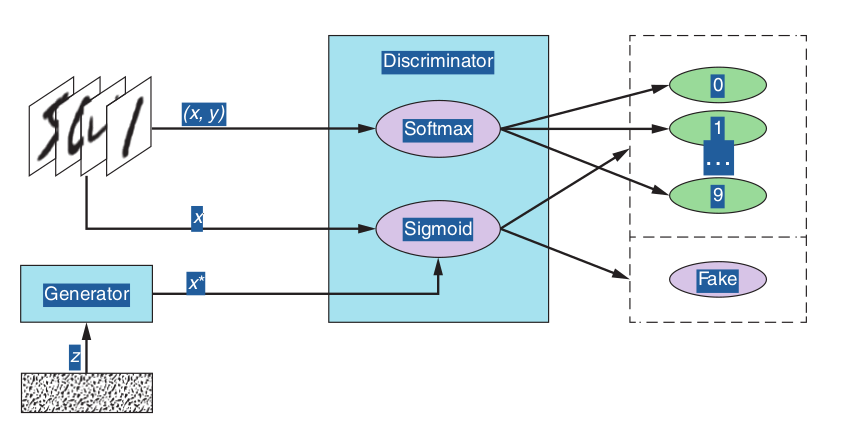

### Generator

In [12]:
# model takes in a random noise vector of z_dim and learns to output a digit
# that is good enough that discriminator can't tell it from an MNIST database image



def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    
    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    
    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))
    

    return model

### Discriminator

In [13]:
# takes input image and classifies it from 0...9


def build_discriminator_net(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))
    model.add(LeakyReLU(alpha=0.01))

    
    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    
    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))

    
    # Flatten the tensor
    model.add(Flatten())
    model.add(Dense(num_classes))

    return model

In [14]:
# discriminator to label class
def build_discriminator_supervised(discriminator_net):

    model = Sequential()
    model.add(discriminator_net)
    model.add(Activation('softmax'))

    return model

In [15]:
# discriminator to id real/fake image
def build_discriminator_unsupervised(discriminator_net):

    model = Sequential()
    model.add(discriminator_net)

    # Transform distribution over real classes into a binary real-vs-fake probability
    def predict(x):
        # 1 - 1/Sum(e^x + 1)  --- almost sigmoid function
        prediction = 1.0 - (1.0 / (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction

    # 'Real-vs-fake' output neuron defined above
    model.add(Lambda(predict))

    return model

## Build the Model

In [16]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

### Discriminator

In [17]:
# Core Discriminator network:
# These layers are shared during supervised and unsupervised training
discriminator_net = build_discriminator_net(img_shape)


# Build & compile the Discriminator for supervised training
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())


# Build & compile the Discriminator for unsupervised training
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy', optimizer=Adam())







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Generator

In [18]:
# Build the Generator
generator = build_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator_unsupervised.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
# Note that we are using the Discriminator version with unsupervised output
gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## Training

In [19]:
supervised_losses = []
iteration_checkpoints = []



def train(iterations, batch_size, sample_interval):

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    
    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get labeled examples
        imgs, labels = batch_labeled(batch_size)
        
############################################################################
        # Get unlabeled examples
        #imgs_unlabeled = batch_unlabeled(batch_size)
        #imgs_unlabeled = batch_holdout(batch_size)
        imgs_unlabeled = batch_submission(batch_size)

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        # Train on real labeled examples
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)

        # Train on real unlabeled examples
        d_loss_real = discriminator_unsupervised.train_on_batch( imgs_unlabeled, real)

        # Train on fake examples
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)

        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))

        if (iteration + 1) % sample_interval == 0:

            # Save Discriminator supervised classification loss to be plotted after training
            supervised_losses.append(d_loss_supervised)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print(
                "%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
                % (iteration + 1, d_loss_supervised, 100 * accuracy,
                   d_loss_unsupervised, g_loss))

## Train the Model and Inspect Output

Note that the `'Discrepancy between trainable weights and collected trainable'` warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

In [20]:
# Set hyperparameters
n_epochs = 10000
batch_size = 32
sample_interval = 10

# Train the SGAN for the specified number of iterations
train(n_epochs, batch_size, sample_interval)

10 [D loss supervised: 0.9728, acc.: 62.50%] [D loss unsupervised: 0.2136] [G loss: 1.914685]
20 [D loss supervised: 0.8467, acc.: 71.88%] [D loss unsupervised: 0.0864] [G loss: 2.276715]
30 [D loss supervised: 0.5146, acc.: 87.50%] [D loss unsupervised: 0.0577] [G loss: 2.293287]
40 [D loss supervised: 0.0942, acc.: 96.88%] [D loss unsupervised: 0.0121] [G loss: 0.118627]
50 [D loss supervised: 0.2594, acc.: 84.38%] [D loss unsupervised: 0.0130] [G loss: 0.109960]
60 [D loss supervised: 0.4897, acc.: 81.25%] [D loss unsupervised: 0.0100] [G loss: 0.290176]
70 [D loss supervised: 0.0869, acc.: 96.88%] [D loss unsupervised: 0.0113] [G loss: 0.200825]
80 [D loss supervised: 0.2476, acc.: 96.88%] [D loss unsupervised: 0.0062] [G loss: 0.098751]
90 [D loss supervised: 0.7032, acc.: 84.38%] [D loss unsupervised: 0.0068] [G loss: 0.066456]
100 [D loss supervised: 0.1681, acc.: 96.88%] [D loss unsupervised: 0.0153] [G loss: 0.100660]
110 [D loss supervised: 0.3165, acc.: 93.75%] [D loss unsup

880 [D loss supervised: 0.1110, acc.: 96.88%] [D loss unsupervised: 0.0112] [G loss: 4.335076]
890 [D loss supervised: 0.0013, acc.: 100.00%] [D loss unsupervised: 0.0069] [G loss: 4.831942]
900 [D loss supervised: 0.0127, acc.: 100.00%] [D loss unsupervised: 0.0284] [G loss: 4.039617]
910 [D loss supervised: 0.0068, acc.: 100.00%] [D loss unsupervised: 0.0087] [G loss: 3.280968]
920 [D loss supervised: 0.0276, acc.: 100.00%] [D loss unsupervised: 0.0087] [G loss: 6.236068]
930 [D loss supervised: 0.0363, acc.: 96.88%] [D loss unsupervised: 0.0067] [G loss: 10.240490]
940 [D loss supervised: 0.1340, acc.: 93.75%] [D loss unsupervised: 0.0026] [G loss: 9.779160]
950 [D loss supervised: 0.1847, acc.: 90.62%] [D loss unsupervised: 0.0112] [G loss: 7.495773]
960 [D loss supervised: 0.1633, acc.: 93.75%] [D loss unsupervised: 0.0124] [G loss: 10.351233]
970 [D loss supervised: 0.0156, acc.: 100.00%] [D loss unsupervised: 0.0033] [G loss: 10.528934]
980 [D loss supervised: 0.0051, acc.: 100.

1730 [D loss supervised: 0.0009, acc.: 100.00%] [D loss unsupervised: 0.0264] [G loss: 8.513269]
1740 [D loss supervised: 0.0869, acc.: 93.75%] [D loss unsupervised: 0.0207] [G loss: 10.548392]
1750 [D loss supervised: 0.0064, acc.: 100.00%] [D loss unsupervised: 0.0014] [G loss: 11.657148]
1760 [D loss supervised: 0.1784, acc.: 96.88%] [D loss unsupervised: 0.0001] [G loss: 15.271610]
1770 [D loss supervised: 0.0064, acc.: 100.00%] [D loss unsupervised: 0.0067] [G loss: 16.040138]
1780 [D loss supervised: 0.0054, acc.: 100.00%] [D loss unsupervised: 0.0003] [G loss: 15.182102]
1790 [D loss supervised: 0.0027, acc.: 100.00%] [D loss unsupervised: 0.0002] [G loss: 14.886357]
1800 [D loss supervised: 0.0151, acc.: 100.00%] [D loss unsupervised: 0.0146] [G loss: 15.464845]
1810 [D loss supervised: 0.0136, acc.: 100.00%] [D loss unsupervised: 0.0012] [G loss: 16.058300]
1820 [D loss supervised: 0.2094, acc.: 96.88%] [D loss unsupervised: 0.0029] [G loss: 13.118861]
1830 [D loss supervised:

2580 [D loss supervised: 0.0100, acc.: 100.00%] [D loss unsupervised: 0.0207] [G loss: 7.505947]
2590 [D loss supervised: 0.0130, acc.: 100.00%] [D loss unsupervised: 0.0226] [G loss: 9.940771]
2600 [D loss supervised: 0.0060, acc.: 100.00%] [D loss unsupervised: 0.0034] [G loss: 14.633560]
2610 [D loss supervised: 0.0227, acc.: 100.00%] [D loss unsupervised: 0.0003] [G loss: 10.294300]
2620 [D loss supervised: 0.0045, acc.: 100.00%] [D loss unsupervised: 0.0020] [G loss: 11.032421]
2630 [D loss supervised: 0.0550, acc.: 96.88%] [D loss unsupervised: 0.0499] [G loss: 10.343866]
2640 [D loss supervised: 0.0073, acc.: 100.00%] [D loss unsupervised: 0.1049] [G loss: 10.475649]
2650 [D loss supervised: 0.1469, acc.: 93.75%] [D loss unsupervised: 0.0021] [G loss: 14.118421]
2660 [D loss supervised: 0.0160, acc.: 100.00%] [D loss unsupervised: 0.0003] [G loss: 10.905329]
2670 [D loss supervised: 0.0154, acc.: 100.00%] [D loss unsupervised: 0.0669] [G loss: 8.300367]
2680 [D loss supervised: 

3430 [D loss supervised: 0.0011, acc.: 100.00%] [D loss unsupervised: 0.0164] [G loss: 11.970142]
3440 [D loss supervised: 0.1095, acc.: 93.75%] [D loss unsupervised: 0.0028] [G loss: 7.400156]
3450 [D loss supervised: 0.0396, acc.: 100.00%] [D loss unsupervised: 0.0195] [G loss: 6.273953]
3460 [D loss supervised: 0.0645, acc.: 96.88%] [D loss unsupervised: 0.0021] [G loss: 10.744535]
3470 [D loss supervised: 0.0037, acc.: 100.00%] [D loss unsupervised: 0.0255] [G loss: 8.147249]
3480 [D loss supervised: 0.0501, acc.: 96.88%] [D loss unsupervised: 0.0071] [G loss: 14.884890]
3490 [D loss supervised: 0.0078, acc.: 100.00%] [D loss unsupervised: 0.1139] [G loss: 13.392856]
3500 [D loss supervised: 0.1003, acc.: 96.88%] [D loss unsupervised: 0.0117] [G loss: 10.717651]
3510 [D loss supervised: 0.0408, acc.: 100.00%] [D loss unsupervised: 0.1202] [G loss: 10.086721]
3520 [D loss supervised: 0.0045, acc.: 100.00%] [D loss unsupervised: 0.0011] [G loss: 10.549773]
3530 [D loss supervised: 0.

4290 [D loss supervised: 0.0160, acc.: 100.00%] [D loss unsupervised: 0.1074] [G loss: 9.775395]
4300 [D loss supervised: 0.0032, acc.: 100.00%] [D loss unsupervised: 0.0517] [G loss: 10.809635]
4310 [D loss supervised: 0.0027, acc.: 100.00%] [D loss unsupervised: 0.0335] [G loss: 8.374022]
4320 [D loss supervised: 0.0329, acc.: 96.88%] [D loss unsupervised: 0.0468] [G loss: 7.623507]
4330 [D loss supervised: 0.0181, acc.: 100.00%] [D loss unsupervised: 0.0282] [G loss: 8.666105]
4340 [D loss supervised: 0.0364, acc.: 100.00%] [D loss unsupervised: 0.0345] [G loss: 10.988132]
4350 [D loss supervised: 0.0063, acc.: 100.00%] [D loss unsupervised: 0.0128] [G loss: 10.299501]
4360 [D loss supervised: 0.0159, acc.: 100.00%] [D loss unsupervised: 0.0190] [G loss: 9.889257]
4370 [D loss supervised: 0.0044, acc.: 100.00%] [D loss unsupervised: 0.0057] [G loss: 13.330047]
4380 [D loss supervised: 0.0745, acc.: 96.88%] [D loss unsupervised: 0.0718] [G loss: 10.955112]
4390 [D loss supervised: 0.

5140 [D loss supervised: 0.0134, acc.: 100.00%] [D loss unsupervised: 0.0001] [G loss: 8.440687]
5150 [D loss supervised: 0.0003, acc.: 100.00%] [D loss unsupervised: 0.0004] [G loss: 7.991748]
5160 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0004] [G loss: 9.530725]
5170 [D loss supervised: 0.0012, acc.: 100.00%] [D loss unsupervised: 0.0007] [G loss: 7.574542]
5180 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.0004] [G loss: 8.107189]
5190 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0005] [G loss: 7.786736]
5200 [D loss supervised: 0.0063, acc.: 100.00%] [D loss unsupervised: 0.0002] [G loss: 13.679113]
5210 [D loss supervised: 0.0039, acc.: 100.00%] [D loss unsupervised: 0.0004] [G loss: 8.255459]
5220 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0004] [G loss: 9.193510]
5230 [D loss supervised: 0.0007, acc.: 100.00%] [D loss unsupervised: 0.0002] [G loss: 9.884266]
5240 [D loss supervised: 0.00

5980 [D loss supervised: 0.0086, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 13.323063]
5990 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.0001] [G loss: 13.551575]
6000 [D loss supervised: 0.0802, acc.: 96.88%] [D loss unsupervised: 0.0001] [G loss: 15.728128]
6010 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 14.696465]
6020 [D loss supervised: 0.0005, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 14.934710]
6030 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.0001] [G loss: 15.916200]
6040 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.0005] [G loss: 14.729388]
6050 [D loss supervised: 0.0027, acc.: 100.00%] [D loss unsupervised: 0.0038] [G loss: 13.847745]
6060 [D loss supervised: 0.0018, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 14.609900]
6070 [D loss supervised: 0.0006, acc.: 100.00%] [D loss unsupervised: 0.0002] [G loss: 14.641918]
6080 [D loss supervis

6830 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0030] [G loss: 14.572318]
6840 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 16.118095]
6850 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 16.090942]
6860 [D loss supervised: 0.0007, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 16.118095]
6870 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 16.107113]
6880 [D loss supervised: 0.0004, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 16.112604]
6890 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 15.550631]
6900 [D loss supervised: 0.0005, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 15.555031]
6910 [D loss supervised: 0.0247, acc.: 96.88%] [D loss unsupervised: 0.0000] [G loss: 13.399611]
6920 [D loss supervised: 0.0016, acc.: 100.00%] [D loss unsupervised: 0.0001] [G loss: 12.523214]
6930 [D loss supervis

7670 [D loss supervised: 0.0004, acc.: 100.00%] [D loss unsupervised: 0.0009] [G loss: 13.497625]
7680 [D loss supervised: 0.0207, acc.: 100.00%] [D loss unsupervised: 0.0001] [G loss: 14.314062]
7690 [D loss supervised: 0.0169, acc.: 100.00%] [D loss unsupervised: 0.0001] [G loss: 15.169658]
7700 [D loss supervised: 0.0103, acc.: 100.00%] [D loss unsupervised: 0.0051] [G loss: 10.240364]
7710 [D loss supervised: 0.0027, acc.: 100.00%] [D loss unsupervised: 0.0004] [G loss: 10.975155]
7720 [D loss supervised: 0.0014, acc.: 100.00%] [D loss unsupervised: 0.0001] [G loss: 13.334202]
7730 [D loss supervised: 0.0013, acc.: 100.00%] [D loss unsupervised: 0.0008] [G loss: 15.731551]
7740 [D loss supervised: 0.0002, acc.: 100.00%] [D loss unsupervised: 0.0001] [G loss: 12.412079]
7750 [D loss supervised: 0.0375, acc.: 96.88%] [D loss unsupervised: 0.0004] [G loss: 12.707997]
7760 [D loss supervised: 0.0004, acc.: 100.00%] [D loss unsupervised: 0.0435] [G loss: 12.159860]
7770 [D loss supervis

8510 [D loss supervised: 0.0012, acc.: 100.00%] [D loss unsupervised: 0.0162] [G loss: 13.794517]
8520 [D loss supervised: 0.0023, acc.: 100.00%] [D loss unsupervised: 0.0114] [G loss: 10.566641]
8530 [D loss supervised: 0.0010, acc.: 100.00%] [D loss unsupervised: 0.0234] [G loss: 8.492386]
8540 [D loss supervised: 0.0017, acc.: 100.00%] [D loss unsupervised: 0.0585] [G loss: 9.609238]
8550 [D loss supervised: 0.0102, acc.: 100.00%] [D loss unsupervised: 0.0004] [G loss: 11.796066]
8560 [D loss supervised: 0.0205, acc.: 100.00%] [D loss unsupervised: 0.1095] [G loss: 8.902712]
8570 [D loss supervised: 0.0026, acc.: 100.00%] [D loss unsupervised: 0.0241] [G loss: 9.332021]
8580 [D loss supervised: 0.0024, acc.: 100.00%] [D loss unsupervised: 0.0319] [G loss: 13.719995]
8590 [D loss supervised: 0.0002, acc.: 100.00%] [D loss unsupervised: 0.0165] [G loss: 13.023214]
8600 [D loss supervised: 0.0022, acc.: 100.00%] [D loss unsupervised: 0.0005] [G loss: 12.747227]
8610 [D loss supervised:

9360 [D loss supervised: 0.0002, acc.: 100.00%] [D loss unsupervised: 0.0546] [G loss: 8.825516]
9370 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0120] [G loss: 6.345797]
9380 [D loss supervised: 0.0241, acc.: 100.00%] [D loss unsupervised: 0.0008] [G loss: 4.552822]
9390 [D loss supervised: 0.0003, acc.: 100.00%] [D loss unsupervised: 0.0070] [G loss: 6.920261]
9400 [D loss supervised: 0.0505, acc.: 96.88%] [D loss unsupervised: 0.0003] [G loss: 7.431367]
9410 [D loss supervised: 0.0061, acc.: 100.00%] [D loss unsupervised: 0.0051] [G loss: 5.516279]
9420 [D loss supervised: 0.0009, acc.: 100.00%] [D loss unsupervised: 0.0008] [G loss: 8.898510]
9430 [D loss supervised: 0.0097, acc.: 100.00%] [D loss unsupervised: 0.0865] [G loss: 5.847692]
9440 [D loss supervised: 0.0007, acc.: 100.00%] [D loss unsupervised: 0.0002] [G loss: 9.786222]
9450 [D loss supervised: 0.0003, acc.: 100.00%] [D loss unsupervised: 0.0003] [G loss: 7.956492]
9460 [D loss supervised: 0.0017

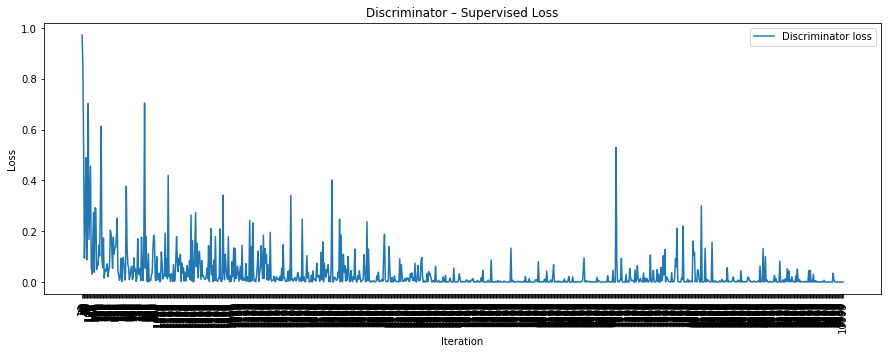

In [21]:
losses = np.array(supervised_losses)

# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses, label="Discriminator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator – Supervised Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

## SGAN Classifier – Training, Test, Holdout Accuracy 


In [22]:
# compute training data accuaracy
x, y = train_set()

_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

30000/30000 [==============================] - 1s 39us/step
Test Accuracy: 98.65%


In [23]:
# compute validation data accuaracy
x, y = test_set()

_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

10000/10000 [==============================] - 0s 33us/step
Test Accuracy: 98.40%


In [24]:
# compute holdout data accuracy
x, y = holdout_set()

_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

10240/10240 [==============================] - 0s 34us/step
Test Accuracy: 73.24%


In [25]:
# create Kaggle submission data
# score was not good enough to bother submitting, code here only to show how to pull out ints from one-hot
x = submission_set()

gan_predictions = discriminator_supervised.predict(x)
print('gan preds', gan_predictions.shape)
gan_preds = np.argmax(gan_predictions, axis = 1)

print(gan_preds)

gan preds (5000, 10)
[3 0 2 ... 1 6 3]


---

# Fully-Supervised Classifier

* use same number of labeled samples
* see diff in number of training epoches needed

In [26]:
# Fully supervised classifier with the same network architecture as the SGAN Discriminator
mnist_classifier = build_discriminator_supervised(build_discriminator_net(img_shape))
mnist_classifier.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

In [27]:
imgs, labels = batch_labeled(num_labeled)


# Train the classifier
training = mnist_classifier.fit(x=imgs,
                                y=labels,
                                batch_size=batch_size,
                                epochs=n_epochs//100,
                                verbose=1)

losses = training.history['loss']
accuracies = training.history['acc']

Epoch 1/100
4000/4000 [==============================] - 1s 230us/step - loss: 0.4196 - acc: 0.8692
Epoch 2/100
4000/4000 [==============================] - 0s 97us/step - loss: 0.1129 - acc: 0.9677
Epoch 3/100
4000/4000 [==============================] - 0s 96us/step - loss: 0.0707 - acc: 0.9820
Epoch 4/100
4000/4000 [==============================] - 0s 96us/step - loss: 0.0440 - acc: 0.9890
Epoch 5/100
4000/4000 [==============================] - 0s 95us/step - loss: 0.0361 - acc: 0.9900
Epoch 6/100
4000/4000 [==============================] - 0s 98us/step - loss: 0.0193 - acc: 0.9948
Epoch 7/100
4000/4000 [==============================] - 0s 98us/step - loss: 0.0151 - acc: 0.9952
Epoch 8/100
4000/4000 [==============================] - 0s 94us/step - loss: 0.0108 - acc: 0.9978
Epoch 9/100
4000/4000 [==============================] - 0s 94us/step - loss: 0.0085 - acc: 0.9978
Epoch 10/100
4000/4000 [==============================] - 0s 98us/step - loss: 0.0064 - acc: 0.9985
Epoch 11

4000/4000 [==============================] - 0s 94us/step - loss: 0.0026 - acc: 0.9990
Epoch 83/100
4000/4000 [==============================] - 0s 95us/step - loss: 0.0012 - acc: 0.9993
Epoch 84/100
4000/4000 [==============================] - 0s 95us/step - loss: 0.0030 - acc: 0.9990
Epoch 85/100
4000/4000 [==============================] - 0s 94us/step - loss: 0.0103 - acc: 0.9968
Epoch 86/100
4000/4000 [==============================] - 0s 95us/step - loss: 0.0115 - acc: 0.9955
Epoch 87/100
4000/4000 [==============================] - 0s 94us/step - loss: 0.0027 - acc: 0.9995
Epoch 88/100
4000/4000 [==============================] - 0s 95us/step - loss: 0.0023 - acc: 0.9990
Epoch 89/100
4000/4000 [==============================] - 0s 97us/step - loss: 0.0044 - acc: 0.9988
Epoch 90/100
4000/4000 [==============================] - 0s 94us/step - loss: 8.5192e-04 - acc: 0.9998
Epoch 91/100
4000/4000 [==============================] - 0s 97us/step - loss: 0.0020 - acc: 0.9998
Epoch 92/

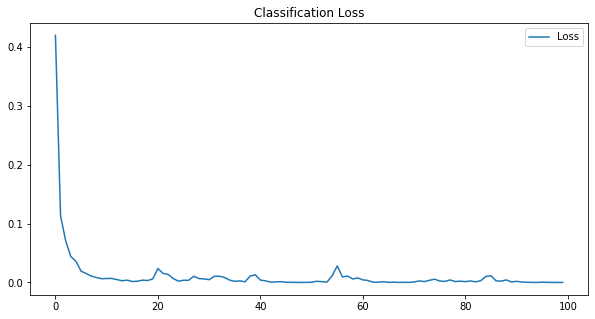

In [28]:
# Plot classification loss
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()

In [29]:
# check training data accuracy

x, y = train_set()
_, accuracy = mnist_classifier.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

30000/30000 [==============================] - 1s 38us/step
Training Accuracy: 98.18%


In [30]:
# check validation data accuracy

x, y = test_set()
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

10000/10000 [==============================] - 0s 35us/step
Test Accuracy: 98.12%


In [31]:
# check holdout data accuracy

x, y = holdout_set()
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

10240/10240 [==============================] - 0s 37us/step
Test Accuracy: 69.14%


In [32]:
# create Kaggle submission data

x = submission_set()

clf_predictions = mnist_classifier.predict(x)
print('clf preds', clf_predictions.shape)
clf_preds = np.argmax(clf_predictions, axis = 1)
print(clf_preds)

clf preds (5000, 10)
[3 0 2 ... 1 6 3]


---